<a href="https://colab.research.google.com/github/mixa15341/Data_Minimg/blob/main/11/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0%20%E2%84%9611.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №11. Прогнозирование временных рядов, используя методы глубокого обучения**

# **Задание:**






## 1. Ознакомьтесь с библиотеками и их инструментарием
## 2. В контексте выбранного Вами набора данных, отберите несколько моделей глубокого обучения, обучите их на своих данных, после чего проведите сравнительный анализ.

## **Подготовка данных**

Загрузим датасет и подготовим данные для моделирования.

Мы будем использовать  датасет https://www.kaggle.com/datasets/bappekim/air-pollution-in-seoul?resource=download

In [2]:
# Подключаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os
from google.colab import drive

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [4]:
# Импортируем датасет
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv('/content/drive/MyDrive/dataset/Measurement_summary.csv')
df.head()

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,1.2,69.0,61.0


In [6]:
# удаление лишних колонок
drop = ['SO2','O3','CO','PM10','PM2.5','Address']
df = df.drop(columns=drop)
df = df[df['Station code'] <= 101]
df.head()

,Measurement date,Station code,Latitude,Longitude,NO2
0,2017-01-01 00:00,101,37.572016,127.005008,0.059
1,2017-01-01 01:00,101,37.572016,127.005008,0.058
2,2017-01-01 02:00,101,37.572016,127.005008,0.056
3,2017-01-01 03:00,101,37.572016,127.005008,0.056
4,2017-01-01 04:00,101,37.572016,127.005008,0.051


In [7]:
print(df.isnull().sum())

Measurement date    0
Station code        0
Latitude            0
Longitude           0
NO2                 0
dtype: int64


In [8]:
# Преобразование даты в числовой формат
df['Measurement date'] = pd.to_datetime(df['Measurement date'])
df['year'] = df['Measurement date'].dt.year
# Фильтруем строки, где время равно 12:00
df = df[df['Measurement date'].dt.time == pd.to_datetime('12:00').time()]
df = df.groupby(
    ['Station code', df['Measurement date'].dt.to_period('M')]
)['NO2'].mean().reset_index()

In [9]:
# Преобразование в временной ряд
pivot = df.pivot(index='Measurement date', columns='Station code', values='NO2').fillna(0)

# Преобразование в numpy массив
data = pivot.values

In [10]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [11]:
look_back = 4  # Количество предыдущих временных шагов для использования в качестве входных данных

In [12]:
import numpy as np

def create_dataset(data, look_back):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

In [13]:
# Разбиение на обучающую и тестовую выборки
X, Y = create_dataset(data_scaled, look_back)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [14]:
print(X_train.shape, Y_train.shape)

(25, 4, 1) (25, 1)


## **1. Рекуррентная нейронная сеть (RNN)**

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
# Построение модели
model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, input_shape=(look_back, X_train.shape[2]), activation='tanh'))
model_rnn.add(Dense(X_train.shape[2]))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')

# Обучение модели
history = model_rnn.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=15,
    validation_data=(X_test, Y_test),
    verbose=2
)

# Прогнозирование
train_predict_rnn = model_rnn.predict(X_train)
test_predict_rnn = model_rnn.predict(X_test)

Epoch 1/100
2/2 - 1s - loss: 0.2591 - val_loss: 0.2226 - 1s/epoch - 552ms/step
Epoch 2/100
2/2 - 0s - loss: 0.1802 - val_loss: 0.1623 - 26ms/epoch - 13ms/step
Epoch 3/100
2/2 - 0s - loss: 0.1535 - val_loss: 0.1454 - 25ms/epoch - 12ms/step
Epoch 4/100
2/2 - 0s - loss: 0.1445 - val_loss: 0.1438 - 24ms/epoch - 12ms/step
Epoch 5/100
2/2 - 0s - loss: 0.1374 - val_loss: 0.1411 - 24ms/epoch - 12ms/step
Epoch 6/100
2/2 - 0s - loss: 0.1235 - val_loss: 0.1377 - 24ms/epoch - 12ms/step
Epoch 7/100
2/2 - 0s - loss: 0.1060 - val_loss: 0.1363 - 43ms/epoch - 22ms/step
Epoch 8/100
2/2 - 0s - loss: 0.0947 - val_loss: 0.1388 - 24ms/epoch - 12ms/step
Epoch 9/100
2/2 - 0s - loss: 0.0866 - val_loss: 0.1443 - 43ms/epoch - 22ms/step
Epoch 10/100
2/2 - 0s - loss: 0.0808 - val_loss: 0.1475 - 25ms/epoch - 13ms/step
Epoch 11/100
2/2 - 0s - loss: 0.0768 - val_loss: 0.1457 - 25ms/epoch - 12ms/step
Epoch 12/100
2/2 - 0s - loss: 0.0713 - val_loss: 0.1406 - 26ms/epoch - 13ms/step
Epoch 13/100
2/2 - 0s - loss: 0.0642 -



1. **Вычисление метрики RMSE**:



  - **Обратите внимание**: Перед вычислением метрики мы приводим предсказанные значения и истинные значения к исходному масштабу с помощью `inverse_transform`, чтобы метрика была интерпретируема.
  - **RMSE (корень из среднеквадратичной ошибки)** оценивает среднее отклонение прогнозов от истинных значений.

In [16]:
# Возвращение данных в исходный масштаб
train_predict_rnn = scaler.inverse_transform(train_predict_rnn)
Y_train_actual_rnn = scaler.inverse_transform(Y_train)
test_predict_rnn = scaler.inverse_transform(test_predict_rnn)
Y_test_actual_rnn = scaler.inverse_transform(Y_test)

In [17]:
# Вычисление RMSE
from sklearn.metrics import mean_squared_error

train_score_rnn = np.sqrt(mean_squared_error(Y_train_actual_rnn, train_predict_rnn))
test_score_rnn = np.sqrt(mean_squared_error(Y_test_actual_rnn, test_predict_rnn))
print(f'RMSE на обучающем наборе: {train_score_rnn:.2f}')
print(f'RMSE на тестовом наборе: {test_score_rnn:.2f}')

RMSE на обучающем наборе: 0.00
RMSE на тестовом наборе: 0.01


2. **Построение графика потерь во время обучения**:

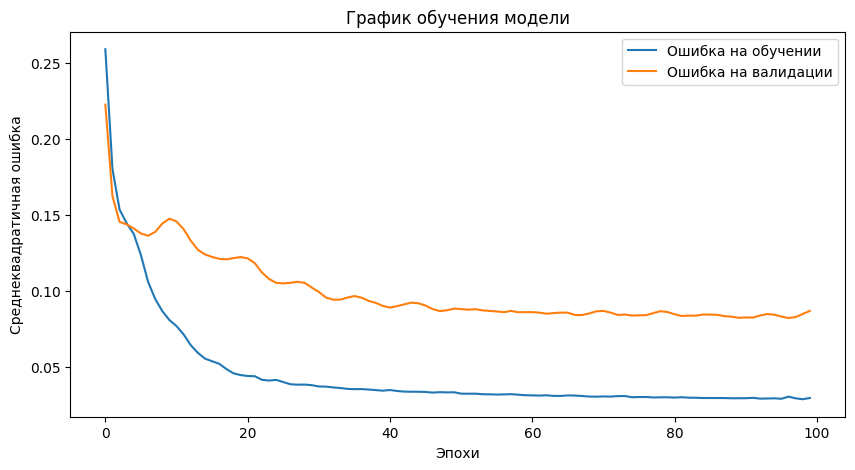

In [18]:
# Построение графика потерь
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Ошибка на обучении')
plt.plot(history.history['val_loss'], label='Ошибка на валидации')
plt.title('График обучения модели')
plt.xlabel('Эпохи')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

3. **Построение графика результатов моделирования**:

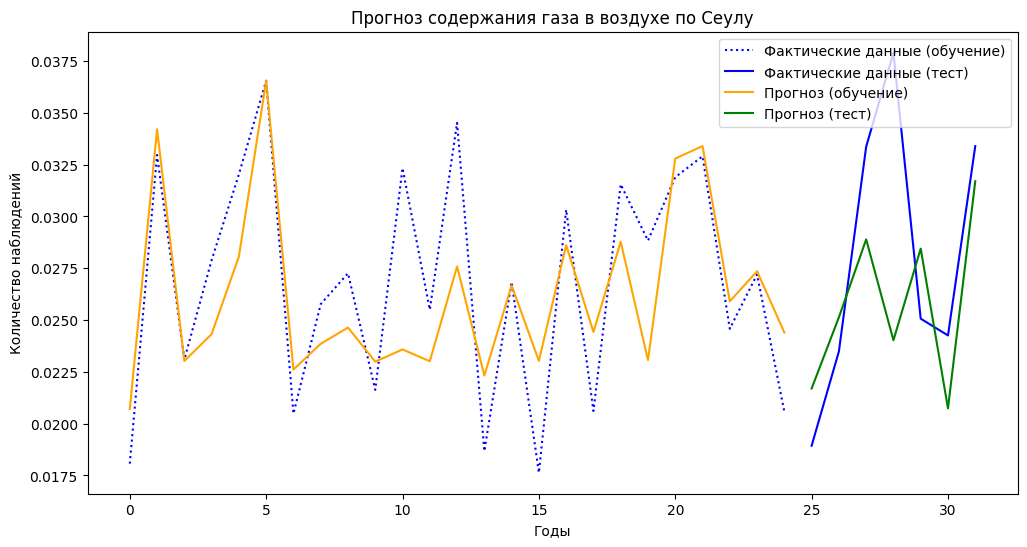

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(Y_train_actual_rnn)), Y_train_actual_rnn[:, 0], label='Фактические данные (обучение)', color='blue', linestyle='dotted')
plt.plot(np.arange(len(Y_train_actual_rnn), len(Y_train_actual_rnn) + len(Y_test_actual_rnn)), Y_test_actual_rnn[:, 0], label='Фактические данные (тест)', color='blue')
plt.plot(np.arange(len(train_predict_rnn)), train_predict_rnn[:, 0], label='Прогноз (обучение)', color='orange')
plt.plot(np.arange(len(Y_train_actual_rnn), len(Y_train_actual_rnn) + len(test_predict_rnn)), test_predict_rnn[:, 0], label='Прогноз (тест)', color='green')
plt.title('Прогноз содержания газа в воздухе по Сеулу')
plt.xlabel('Годы')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

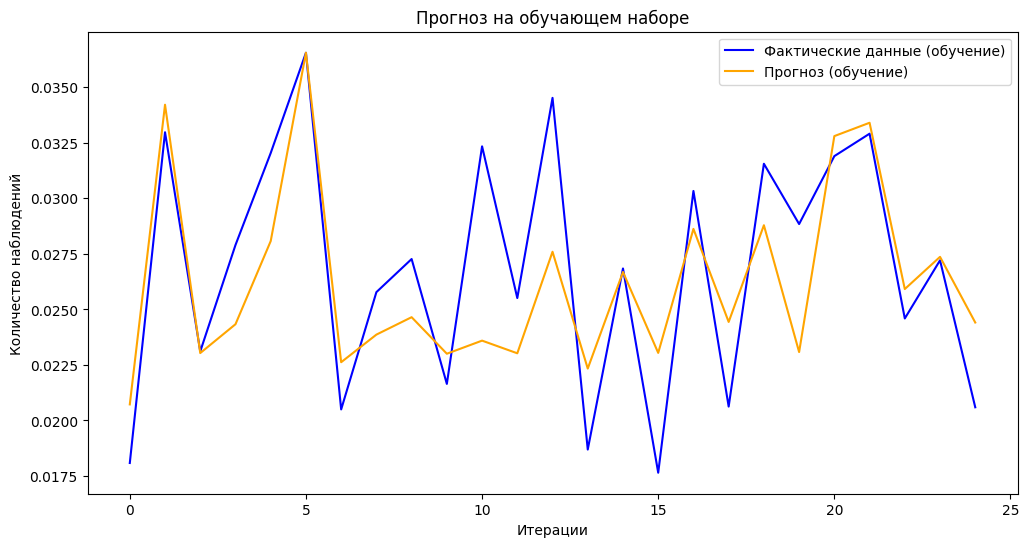

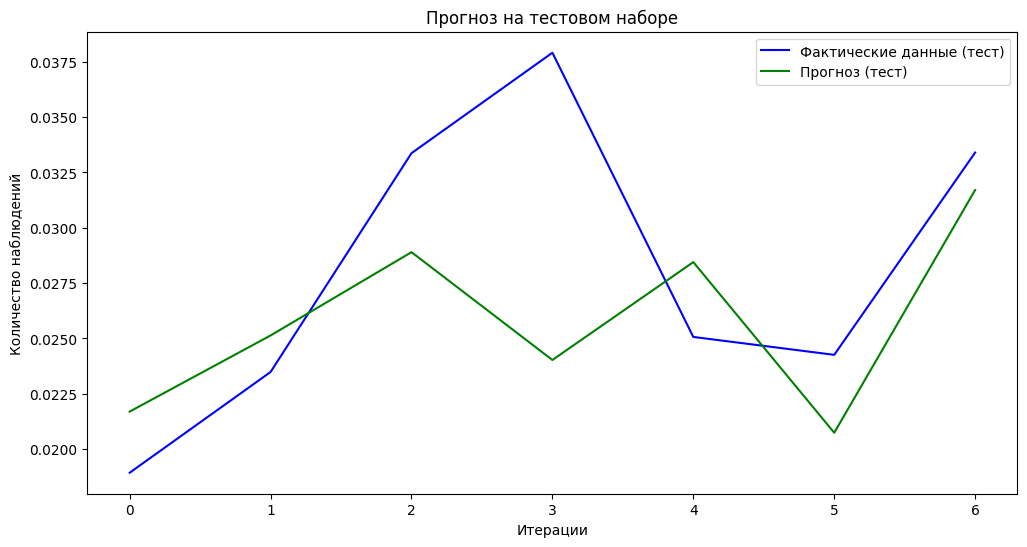

In [24]:
# Визуализация результатов на обучающем наборе
plt.figure(figsize=(12, 6))
plt.plot(Y_train_actual_rnn[:, 0], label='Фактические данные (обучение)', color='blue')
plt.plot(train_predict_rnn[:, 0], label='Прогноз (обучение)', color='orange')
plt.title('Прогноз на обучающем наборе')
plt.xlabel('Итерации')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

# Визуализация результатов на тестовом наборе
plt.figure(figsize=(12, 6))
plt.plot(Y_test_actual_rnn[:, 0], label='Фактические данные (тест)', color='blue')
plt.plot(test_predict_rnn[:, 0], label='Прогноз (тест)', color='green')
plt.title('Прогноз на тестовом наборе')
plt.xlabel('Итерации')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

## **2. Долгая краткосрочная память (LSTM)**




In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Создание модели
model_lstm = Sequential()
model_lstm.add(LSTM(100, return_sequences=True, input_shape=(look_back, X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(25))
model_lstm.add(Dense(X_train.shape[2]))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Обучение модели
history_lstm = model_lstm.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=15,
    validation_data=(X_test, Y_test),
    verbose=2
)

# Прогнозирование
train_predict_lstm = model_lstm.predict(X_train)
test_predict_lstm = model_lstm.predict(X_test)

Epoch 1/100
2/2 - 6s - loss: 0.2710 - val_loss: 0.3304 - 6s/epoch - 3s/step
Epoch 2/100
2/2 - 0s - loss: 0.2455 - val_loss: 0.2983 - 38ms/epoch - 19ms/step
Epoch 3/100
2/2 - 0s - loss: 0.2183 - val_loss: 0.2644 - 43ms/epoch - 21ms/step
Epoch 4/100
2/2 - 0s - loss: 0.1899 - val_loss: 0.2282 - 36ms/epoch - 18ms/step
Epoch 5/100
2/2 - 0s - loss: 0.1606 - val_loss: 0.1903 - 48ms/epoch - 24ms/step
Epoch 6/100
2/2 - 0s - loss: 0.1322 - val_loss: 0.1533 - 36ms/epoch - 18ms/step
Epoch 7/100
2/2 - 0s - loss: 0.1014 - val_loss: 0.1233 - 36ms/epoch - 18ms/step
Epoch 8/100
2/2 - 0s - loss: 0.0881 - val_loss: 0.1077 - 37ms/epoch - 19ms/step
Epoch 9/100
2/2 - 0s - loss: 0.0888 - val_loss: 0.1110 - 36ms/epoch - 18ms/step
Epoch 10/100
2/2 - 0s - loss: 0.1033 - val_loss: 0.1143 - 34ms/epoch - 17ms/step
Epoch 11/100
2/2 - 0s - loss: 0.1008 - val_loss: 0.1095 - 36ms/epoch - 18ms/step
Epoch 12/100
2/2 - 0s - loss: 0.0902 - val_loss: 0.1051 - 69ms/epoch - 35ms/step
Epoch 13/100
2/2 - 0s - loss: 0.0832 - va

In [26]:
# Возвращение данных в исходный масштаб
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
Y_train_actual_lstm = scaler.inverse_transform(Y_train)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)
Y_test_actual_lstm = scaler.inverse_transform(Y_test)

# Вычисление RMSE
train_score_lstm = np.sqrt(mean_squared_error(Y_train_actual_lstm, train_predict_lstm))
test_score_lstm = np.sqrt(mean_squared_error(Y_test_actual_lstm, test_predict_lstm))
print(f'RMSE на обучающем наборе: {train_score_lstm:.2f}')
print(f'RMSE на тестовом наборе: {test_score_lstm:.2f}')

RMSE на обучающем наборе: 0.00
RMSE на тестовом наборе: 0.01


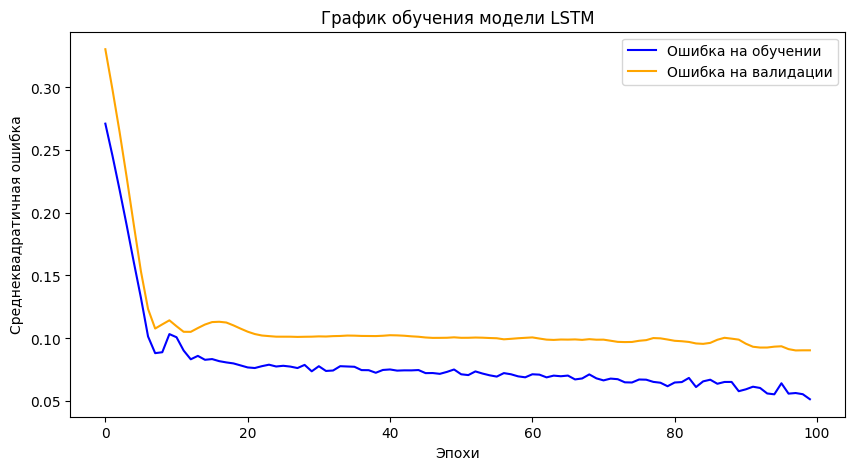

In [27]:
# Построение графика потерь
plt.figure(figsize=(10, 5))
plt.plot(history_lstm.history['loss'], label='Ошибка на обучении', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Ошибка на валидации', color='orange')
plt.title('График обучения модели LSTM')
plt.xlabel('Эпохи')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

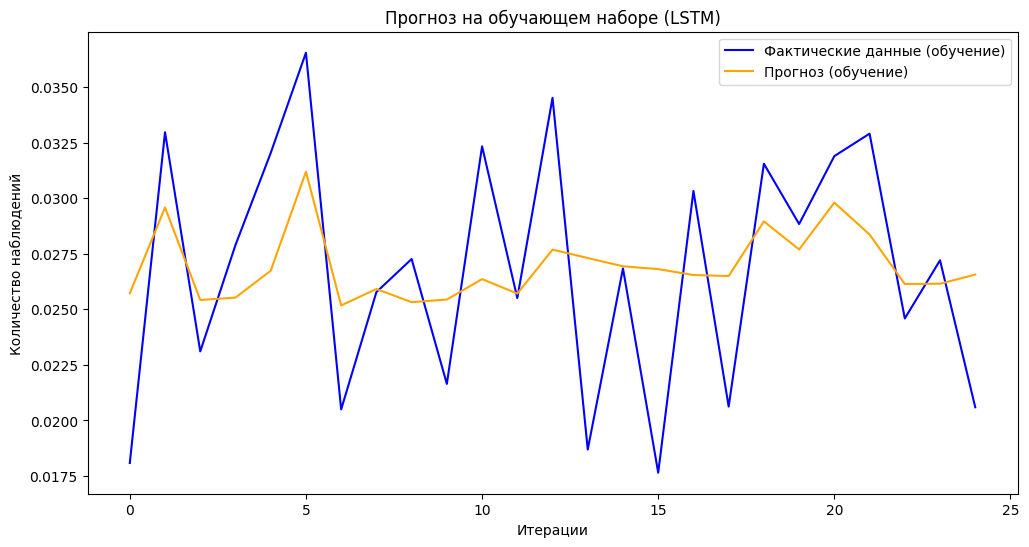

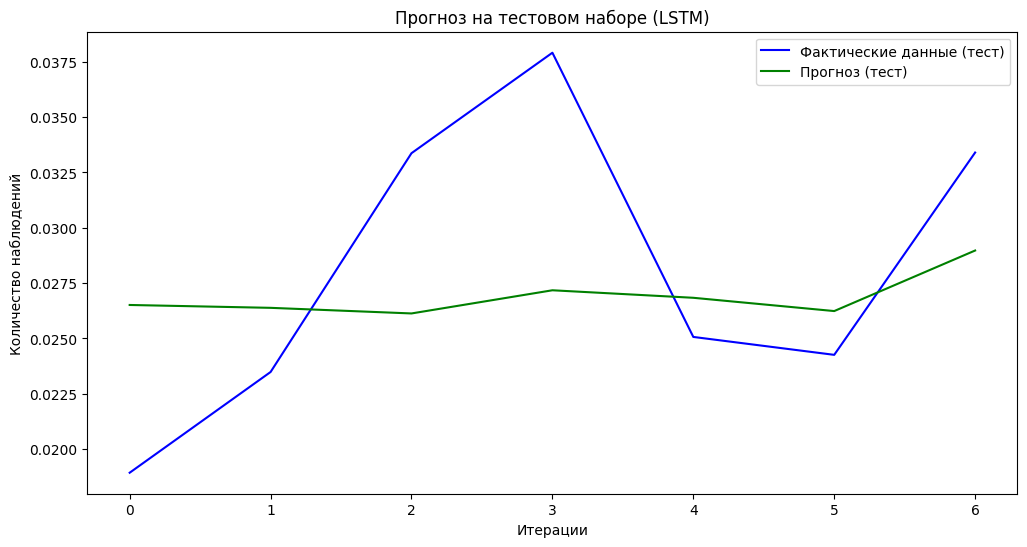

In [28]:
# Визуализация результатов на обучающем наборе
plt.figure(figsize=(12, 6))
plt.plot(Y_train_actual_lstm[:, 0], label='Фактические данные (обучение)', color='blue')
plt.plot(train_predict_lstm[:, 0], label='Прогноз (обучение)', color='orange')
plt.title('Прогноз на обучающем наборе (LSTM)')
plt.xlabel('Итерации')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

# Визуализация результатов на тестовом наборе
plt.figure(figsize=(12, 6))
plt.plot(Y_test_actual_lstm[:, 0], label='Фактические данные (тест)', color='blue')
plt.plot(test_predict_lstm[:, 0], label='Прогноз (тест)', color='green')
plt.title('Прогноз на тестовом наборе (LSTM)')
plt.xlabel('Итерации')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

## **3. Управляемые рекуррентные блоки (GRU)**



In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
# Создание модели
model_gru = Sequential()
model_gru.add(GRU(100, return_sequences=True, input_shape=(look_back, X_train.shape[2])))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(50, return_sequences=True))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(25))
model_gru.add(Dense(X_train.shape[2]))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

# Обучение модели
history_gru = model_gru.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=15,
    validation_data=(X_test, Y_test),
    verbose=2
)

# Прогнозирование
train_predict_gru = model_gru.predict(X_train)
test_predict_gru = model_gru.predict(X_test)

Epoch 1/100
2/2 - 6s - loss: 0.2839 - val_loss: 0.2916 - 6s/epoch - 3s/step
Epoch 2/100
2/2 - 0s - loss: 0.1970 - val_loss: 0.2056 - 50ms/epoch - 25ms/step
Epoch 3/100
2/2 - 0s - loss: 0.1301 - val_loss: 0.1432 - 36ms/epoch - 18ms/step
Epoch 4/100
2/2 - 0s - loss: 0.1030 - val_loss: 0.1097 - 36ms/epoch - 18ms/step
Epoch 5/100
2/2 - 0s - loss: 0.0793 - val_loss: 0.1073 - 35ms/epoch - 18ms/step
Epoch 6/100
2/2 - 0s - loss: 0.0854 - val_loss: 0.1156 - 36ms/epoch - 18ms/step
Epoch 7/100
2/2 - 0s - loss: 0.0847 - val_loss: 0.1152 - 53ms/epoch - 27ms/step
Epoch 8/100
2/2 - 0s - loss: 0.0918 - val_loss: 0.1083 - 72ms/epoch - 36ms/step
Epoch 9/100
2/2 - 0s - loss: 0.0840 - val_loss: 0.1037 - 62ms/epoch - 31ms/step
Epoch 10/100
2/2 - 0s - loss: 0.0727 - val_loss: 0.1039 - 59ms/epoch - 29ms/step
Epoch 11/100
2/2 - 0s - loss: 0.0770 - val_loss: 0.1073 - 58ms/epoch - 29ms/step
Epoch 12/100
2/2 - 0s - loss: 0.0833 - val_loss: 0.1109 - 59ms/epoch - 30ms/step
Epoch 13/100
2/2 - 0s - loss: 0.0740 - va

In [30]:
# Возвращение данных в исходный масштаб
train_predict_gru = scaler.inverse_transform(train_predict_gru)
Y_train_actual_gru = scaler.inverse_transform(Y_train)
test_predict_gru = scaler.inverse_transform(test_predict_gru)
Y_test_actual_gru = scaler.inverse_transform(Y_test)

# Вычисление RMSE
train_score_gru = np.sqrt(mean_squared_error(Y_train_actual_gru, train_predict_gru))
test_score_gru = np.sqrt(mean_squared_error(Y_test_actual_gru, test_predict_gru))
print(f'RMSE на обучающем наборе: {train_score_gru:.2f}')
print(f'RMSE на тестовом наборе: {test_score_gru:.2f}')

RMSE на обучающем наборе: 0.00
RMSE на тестовом наборе: 0.01


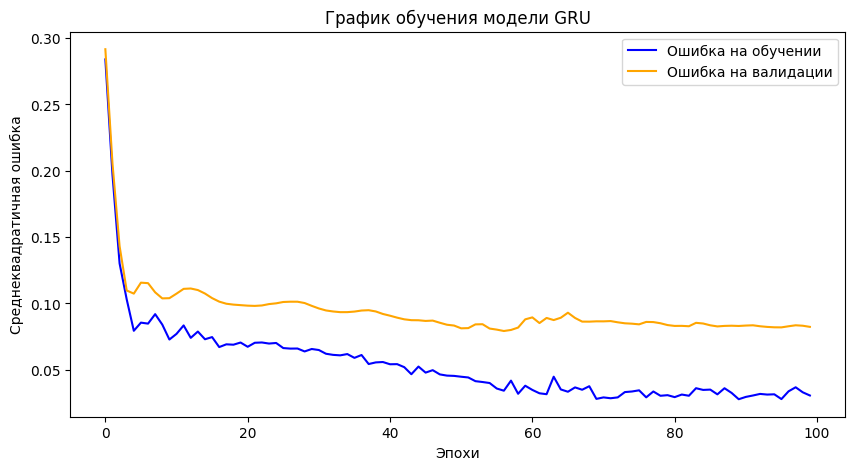

In [31]:
# Построение графика потерь
plt.figure(figsize=(10, 5))
plt.plot(history_gru.history['loss'], label='Ошибка на обучении', color='blue')
plt.plot(history_gru.history['val_loss'], label='Ошибка на валидации', color='orange')
plt.title('График обучения модели GRU')
plt.xlabel('Эпохи')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

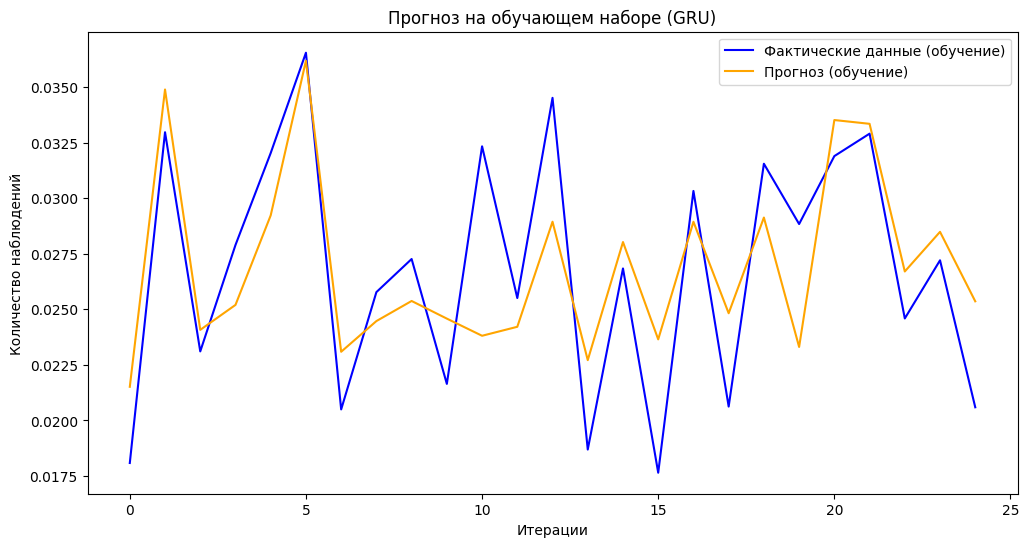

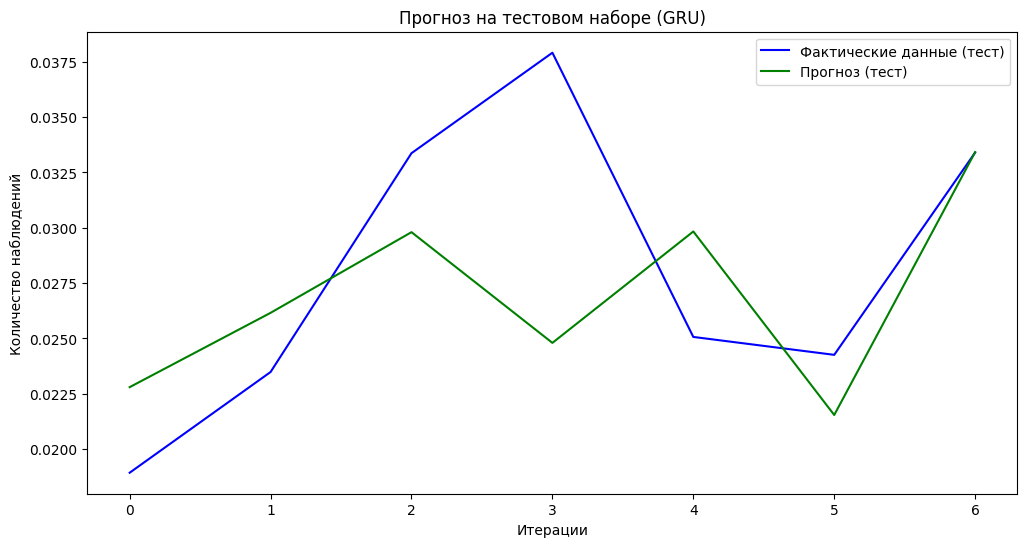

In [32]:
# Визуализация результатов на обучающем наборе
plt.figure(figsize=(12, 6))
plt.plot(Y_train_actual_gru[:, 0], label='Фактические данные (обучение)', color='blue')
plt.plot(train_predict_gru[:, 0], label='Прогноз (обучение)', color='orange')
plt.title('Прогноз на обучающем наборе (GRU)')
plt.xlabel('Итерации')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

# Визуализация результатов на тестовом наборе
plt.figure(figsize=(12, 6))
plt.plot(Y_test_actual_gru[:, 0], label='Фактические данные (тест)', color='blue')
plt.plot(test_predict_gru[:, 0], label='Прогноз (тест)', color='green')
plt.title('Прогноз на тестовом наборе (GRU)')
plt.xlabel('Итерации')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

### **4. N-BEATS**

In [161]:
# Установка пакета nbeats-keras
!pip install nbeats-keras

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 858.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 88.2 MB/s

In [20]:
from nbeats_keras.model import NBeatsNet
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
# Параметры модели
input_dim = X_train.shape[2]  # Количество признаков
backcast_length = look_back  # Длина истории
forecast_length = X_train.shape[2]  # Прогнозируем все признаки, а не одно значение
num_epochs = 5  # Для тестирования можно уменьшить количество эпох

# Создание упрощенной модели N-BEATS
model_nbeats = NBeatsNet(
    input_dim=input_dim,
    backcast_length=backcast_length,
    forecast_length=forecast_length,  # Прогнозируем все признаки
    stack_types=(NBeatsNet.GENERIC_BLOCK,),  # Один блок
    nb_blocks_per_stack=1,  # Уменьшаем количество блоков
    thetas_dim=(4,),  # Уменьшаем размер тета
    share_weights_in_stack=False,  # Упростим модель
    hidden_layer_units=16  # Уменьшаем количество нейронов
)

# Оптимизатор
optimizer = Adam(learning_rate=0.001)

# Компиляция модели с run_eagerly=True для отладки
model_nbeats.compile(loss='mean_squared_error', optimizer=optimizer, run_eagerly=True)

# Проверьте размерность данных
print("Размер X_train:", X_train.shape)
print("Размер Y_train:", Y_train.shape)

# Индексация на 30% данных
X_train_subset = X_train[:int(0.1 * len(X_train))]
Y_train_subset = Y_train[:int(0.1 * len(Y_train))]

# Проверьте размерность подмножества данных
print("Размер X_train_subset:", X_train_subset.shape)
print("Размер Y_train_subset:", Y_train_subset.shape)

# Обучение модели на 30% данных
history_nbeats = model_nbeats.fit(
    X_train_subset,  # Используем только 30% данных для обучения
    Y_train_subset,  # Используем только 30% целевых данных
    validation_data=(X_test, Y_test),
    epochs=num_epochs,
    batch_size=8,  # Размер батча уменьшен
    verbose=2
)

# Прогнозирование
train_predict_nbeats = model_nbeats.predict(X_train_subset)
test_predict_nbeats = model_nbeats.predict(X_test)

Размер X_train: (25, 4, 1)
Размер Y_train: (25, 1)
Размер X_train_subset: (2, 4, 1)
Размер Y_train_subset: (2, 1)
Epoch 1/5
1/1 - 0s - loss: 0.2610 - val_loss: 0.3478 - 137ms/epoch - 137ms/step
Epoch 2/5
1/1 - 0s - loss: 0.2481 - val_loss: 0.3327 - 67ms/epoch - 67ms/step
Epoch 3/5
1/1 - 0s - loss: 0.2354 - val_loss: 0.3185 - 72ms/epoch - 72ms/step
Epoch 4/5
1/1 - 0s - loss: 0.2231 - val_loss: 0.3050 - 66ms/epoch - 66ms/step
Epoch 5/5
1/1 - 0s - loss: 0.2109 - val_loss: 0.2920 - 54ms/epoch - 54ms/step
1/1 [==============================] - 0s 19ms/step


In [21]:
# Прогнозирование и восстановление масштаба данных
train_predict_nbeats_reshaped = train_predict_nbeats.reshape(-1, X_train.shape[2])  # Преобразование в 2D (по числу признаков)
train_predict_nbeats_inversed = scaler.inverse_transform(train_predict_nbeats_reshaped)

Y_train_actual = Y_train_subset.reshape(-1, X_train.shape[2])  # Преобразование целевого массива в нужный формат
Y_train_actual_inversed = scaler.inverse_transform(Y_train_actual)

test_predict_nbeats_reshaped = test_predict_nbeats.reshape(-1, X_train.shape[2])  # Преобразование в 2D
test_predict_nbeats_inversed = scaler.inverse_transform(test_predict_nbeats_reshaped)

Y_test_actual = Y_test.reshape(-1, X_train.shape[2])  # Преобразование целевого массива
Y_test_actual_inversed = scaler.inverse_transform(Y_test_actual)

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Вычисление метрик ошибки
train_mse = mean_squared_error(Y_train_actual_inversed, train_predict_nbeats_inversed)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(Y_train_actual_inversed, train_predict_nbeats_inversed)

print('Метрики на обучающей выборке:')
print(f'MSE: {train_mse:.2f}')
print(f'RMSE: {train_rmse:.2f}')
print(f'MAE: {train_mae:.2f}')

test_mse = mean_squared_error(Y_test_actual_inversed, test_predict_nbeats_inversed)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(Y_test_actual_inversed, test_predict_nbeats_inversed)

print('\nМетрики на тестовой выборке:')
print(f'MSE: {test_mse:.2f}')
print(f'RMSE: {test_rmse:.2f}')
print(f'MAE: {test_mae:.2f}')

Метрики на обучающей выборке:
MSE: 0.00
RMSE: 0.01
MAE: 0.01

Метрики на тестовой выборке:
MSE: 0.00
RMSE: 0.01
MAE: 0.01


Сравнение рассмотренных моделей

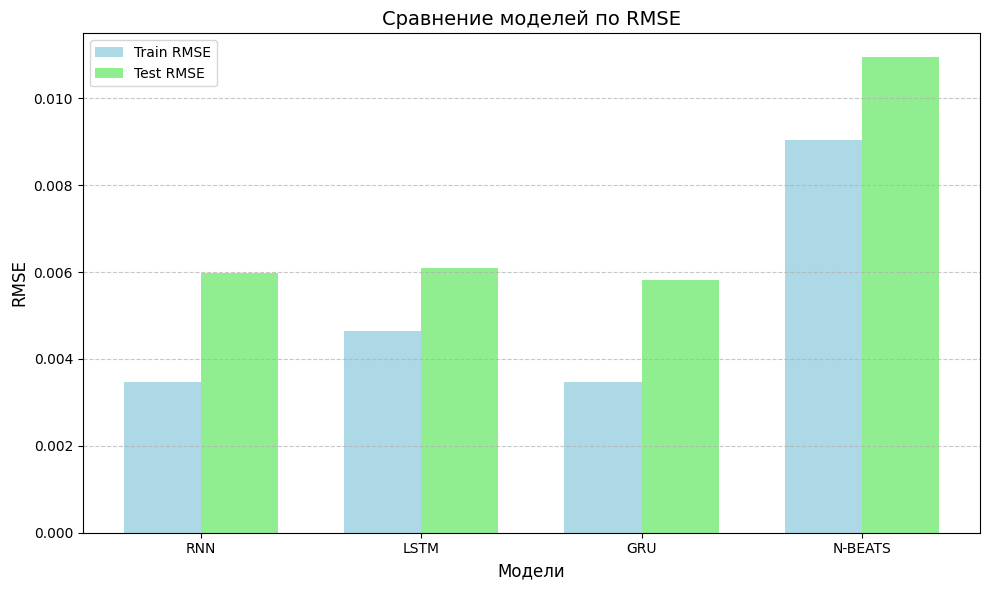

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Названия моделей
models = ['RNN', 'LSTM', 'GRU', 'N-BEATS']

# Метрики (примерные значения, замените на свои)
train_rmse = [train_score_rnn, train_score_lstm, train_score_gru, train_rmse]  # RMSE на обучении
test_rmse = [test_score_rnn, test_score_lstm, test_score_gru, test_rmse]       # RMSE на тесте

# Ширина столбцов
bar_width = 0.35

# Позиции для столбцов
x = np.arange(len(models))

# Создание фигуры
plt.figure(figsize=(10, 6))

# Построение столбчатой диаграммы
plt.bar(x - bar_width / 2, train_rmse, width=bar_width, label='Train RMSE', color='lightblue')
plt.bar(x + bar_width / 2, test_rmse, width=bar_width, label='Test RMSE', color='lightgreen')

# Настройка осей
plt.xlabel('Модели', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Сравнение моделей по RMSE', fontsize=14)
plt.xticks(x, models)  # Установка меток для оси X
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Отображение диаграммы
plt.tight_layout()
plt.show()